In [1]:
import os
from os import listdir
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
os.getcwd()

'C:\\Users\\ASUS\\Karima'

In [3]:
os.chdir("C:/")

In [4]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('dataset/facemask-dataset/yes')))
print("The number of images with facemask labelled 'no':",len(os.listdir('dataset/facemask-dataset/no')))

The number of images with facemask labelled 'yes': 71
The number of images with facemask labelled 'no': 71


In [5]:
def data_summary(main_path):
    
    yes_path = main_path+'yesreal'
    no_path = main_path+'noreal'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = 'dataset/facemask-dataset/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 1372
Percentage of positive examples: 50.0%, number of pos examples: 686
Percentage of negative examples: 50.0%, number of neg examples: 686


In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)
        
        
YES_SOURCE_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/yesreal/"
TRAINING_YES_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/training/yes1/"
TESTING_YES_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/testing/yes1/"
NO_SOURCE_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/noreal/"
TRAINING_NO_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/training/no1/"
TESTING_NO_DIR = "C:\\Users\ASUS\Karima/facemask-dataset/trial1/augmented data1/testing/no1/"
split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [7]:
print("The number of images with facemask in the training set labelled 'yes':", len(os.listdir('dataset/facemask-dataset/trial1/augmented data1/training/yes1')))
print("The number of images with facemask in the test set labelled 'yes':", len(os.listdir('dataset/facemask-dataset/trial1/augmented data1/testing/yes1')))
print("The number of images without facemask in the training set labelled 'no':", len(os.listdir('dataset/facemask-dataset/trial1/augmented data1/training/no1')))
print("The number of images without facemask in the test set labelled 'no':", len(os.listdir('dataset/facemask-dataset/trial1/augmented data1/testing/no1')))

The number of images with facemask in the training set labelled 'yes': 548
The number of images with facemask in the test set labelled 'yes': 138
The number of images without facemask in the training set labelled 'no': 548
The number of images without facemask in the test set labelled 'no': 138


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [9]:
TRAINING_DIR = "dataset/facemask-dataset/trial1/augmented data1/training"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "dataset/facemask-dataset/trial1/augmented data1/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1096 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
110/110 [==============================] - 115s 1s/step - loss: 0.2967 - acc: 0.8878 - val_loss: 0.1295 - val_acc: 0.9601
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/10
110/110 [==============================] - 145s 1s/step - loss: 0.2599 - acc: 0.9033 - val_loss: 0.1240 - val_acc: 0.9674
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/10
110/110 [==============================] - 114s 1s/step - loss: 0.2059 - acc: 0.9224 - val_loss: 0.1759 - val_acc: 0.9348
Epoch 4/10
110/110 [==============================] - 124s 1s/step - loss: 0.1612 - acc: 0.9398 - val_loss: 0.1943 - val_acc: 0.9203
Epoch 5/10
110/110 [==============================] - 104s 948ms/step - loss: 0.1804 - acc: 0.9279 - val_loss: 0.0742 - val_acc: 0.9855
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/10
110/110 [==============================] - 106s 964ms/step - loss: 0.2963 - acc: 0.8832 - val_loss: 0.3839 - val_acc: 0.8080
Epoch 7/10
110/110 [==

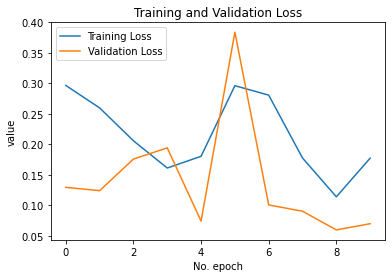

In [12]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [13]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
face_clsfr=cv2.CascadeClassifier('dataset/facemask-dataset/haarcascade_frontalface_default.xml')

In [28]:
labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('dataset/facemask-dataset/haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()